In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore
from natsort import natsorted

from __init__ import *
import snmcseq_utils
from snmcseq_utils import cd
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_labels 
from CEMBA_run_tsne import run_tsne
from CEMBA_clustering_louvain_jaccard import louvain_jaccard
from CEMBA_update_mysql import connect_sql 

In [2]:
import importlib
importlib.reload(snmcseq_utils)
# import CEMBA_clustering_louvain_jaccard
# importlib.reload(CEMBA_clustering_louvain_jaccard)
# from CEMBA_clustering_louvain_jaccard import louvain_jaccard

# import CEMBA_run_tsne
# importlib.reload(CEMBA_run_tsne)
# from CEMBA_run_tsne import run_tsne

log = create_logger()
ens = 'Ens10'
context = 'CH'

# snmCSeq preprocessing

In [3]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [4]:
def gene_id_to_name(gene_id, df_genes):
    """df_genes
    """
    return df_genes.loc[gene_id, 'gene_name']


In [7]:
# get gene*cell matrix (methylation)
fm = os.path.join(PATH_ENSEMBLES, ens, 'binc', 'binc_m{}_100000_{}.tsv.bgz'.format(context, ens))
df_m = pd.read_table(fm, index_col=['chr', 'start'], compression='gzip')
print(df_m.shape)
df_m.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [337]:
# get tsne and clustering (methylation)
database = DATABASE
engine = connect_sql(database) 
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k5'
sql = """SELECT cell_name, tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}
        FROM {} 
        JOIN cells ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                                       ens, ens)

df_info_m = pd.read_sql(sql, engine, index_col='cell_name')
print(df_info_m.shape)
df_info_m.head()

(5352, 4)


,tsne_x_mCHmCG_ndim2_perp30,tsne_y_mCHmCG_ndim2_perp30,cluster_mCHmCG_lv_npc50_k5,annotation_mCHmCG_lv_npc50_k5
cell_name,,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,-17.9718,-45.7888,31,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,-72.3889,-32.8037,23,mL5-1
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,34.1628,-49.8856,21,mL4
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,-1.2001,-15.6003,24,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,34.9378,-48.1781,47,mL4


In [338]:
# gene annotation
sql = """SELECT * FROM genes"""
df_genes = pd.read_sql(sql, engine, index_col='gene_id')
print(df_genes.shape)
df_genes.head()

(53379, 6)


,gene_name,chr,start,end,strand,gene_type
gene_id,,,,,,
ENSMUSG00000000001.4,Gnai3,chr3,108107280,108146146,-,protein_coding
ENSMUSG00000000003.15,Pbsn,chrX,77837901,77853623,-,protein_coding
ENSMUSG00000000028.14,Cdc45,chr16,18780447,18811987,-,protein_coding
ENSMUSG00000000031.16,H19,chr7,142575529,142578143,-,lincRNA
ENSMUSG00000000037.16,Scml2,chrX,161117193,161258213,+,protein_coding


In [353]:
# cluster and annotation
df_clst_annot_m = df_info_m[
    ['cluster_'+cluster_type, 'annotation_'+cluster_type]].groupby('cluster_'+cluster_type).first().fillna('Glia/Unlabeled')
df_clst_annot_m.shape

(88, 1)

In [355]:
# get gene*cluster matrix (methylation)
clusters_mc_c = snmcseq_utils.get_cluster_mc_c(ens, context, genome_regions='genebody', 
                     cluster_col='cluster_'+cluster_type, database=database)
clusters_mcc = get_mcc(clusters_mc_c, base_call_cutoff=1000, sufficient_coverage_fraction=1)
clusters_mcc.columns = [col[:-len('_mcc')] 
                        + '_' + df_clst_annot_m.loc[int(col[len('cluster_'):-len('_mcc')]), 'annotation_'+cluster_type]
                        for col in clusters_mcc.columns]

# clusters_mcc.index = [gene_id_to_name(gene_id, df_genes) for gene_id in clusters_mcc.index]

print(clusters_mcc.shape)
clusters_mcc.head()

03/29/2018 04:16:02 PM Found gene*cell matrix in /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/gene_level/genebody_mCH_Ens10.tsv.bgz
03/29/2018 04:18:55 PM Output shape: (51772, 176)
03/29/2018 04:18:55 PM Getting mcc matrix from mc and c
03/29/2018 04:18:55 PM base_call_cutoff=1000, sufficient_coverage_fraction=1
03/29/2018 04:18:55 PM Matrix size before pruning... (51772, 176)
03/29/2018 04:18:55 PM Matrix size after pruning... (9893, 176)
03/29/2018 04:18:56 PM (9893, 88)
03/29/2018 04:18:56 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(9893, 88)


,cluster_1_mL6-2,cluster_2_mDL-2,cluster_3_mL4,cluster_4_mL6-2,cluster_5_mL2/3,cluster_6_Glia/Unlabeled,cluster_7_mL2/3,cluster_8_mL5-1,cluster_9_mL2/3,cluster_10_mL4,...,cluster_79_Glia/Unlabeled,cluster_80_mSst-1,cluster_81_mL6-2,cluster_82_mL4,cluster_83_mNdnf-2,cluster_84_Glia/Unlabeled,cluster_85_Glia/Unlabeled,cluster_86_Glia/Unlabeled,cluster_87_Glia/Unlabeled,cluster_88_Glia/Unlabeled
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951.5,0.011319,0.014374,0.013793,0.011177,0.016467,0.018484,0.013623,0.012791,0.017682,0.014384,...,0.016429,0.013652,0.012785,0.015664,0.010661,0.005649,0.014539,0.013598,0.013658,0.012437
ENSMUSG00000089699.1,0.011498,0.013787,0.015376,0.011408,0.016455,0.022069,0.013681,0.013572,0.016942,0.016025,...,0.017347,0.015121,0.012780,0.017115,0.008593,0.005021,0.011142,0.015520,0.015613,0.013268
ENSMUSG00000102343.1,0.020205,0.019368,0.017743,0.018447,0.021421,0.008467,0.022478,0.019806,0.024785,0.017163,...,0.012773,0.033589,0.021254,0.015459,0.011478,0.003817,0.022213,0.033161,0.012777,0.026532
ENSMUSG00000025900.12,0.014901,0.016428,0.015867,0.014738,0.019891,0.007339,0.017826,0.019571,0.020294,0.015213,...,0.009789,0.030970,0.017107,0.014154,0.009982,0.005229,0.021235,0.033294,0.009253,0.027401
ENSMUSG00000104217.1,0.012736,0.016626,0.013573,0.012654,0.016538,0.008281,0.017690,0.020271,0.018350,0.013557,...,0.016435,0.022939,0.013517,0.011018,0.008301,0.004444,0.012207,0.018542,0.012708,0.023473


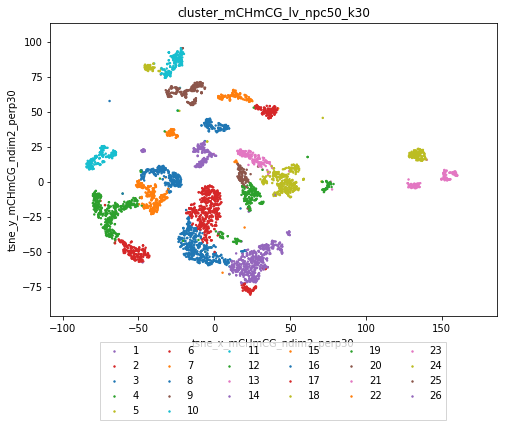

In [236]:
# plot clustering (methylation)
plot_tsne_labels(df_info_m, 
                 tx='tsne_x_'+tsne_type, 
                 ty='tsne_y_'+tsne_type, 
                 tc='cluster_'+cluster_type, 
                 legend_mode=1, s=2) 

# ATAC preprocessing

In [248]:
# get gene*cell matrix (ATAC)

# f = '/cndd/projects/Public_Datasets/CEMBA/integrated/test/counts_corrected.tsv'

f = '/cndd/Public_Datasets/CEMBA/snATACSeq/Datasets/CEMBA_3C_171206/CEMBA_3C_171206_merged.gene10kb.counts.tsv'
df = pd.read_table(f, index_col='gene')
print(df.shape)
df.head()


(53379, 9787)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,AGCGATAGAACCAGGTGGATACTACAGGACGT,AGCGATAGAACCAGGTTAAGATCCGGCTCTGA,AGCGATAGAAGAGGCAAAGGAGTAAGGCGAAG,AGCGATAGAAGAGGCAAAGGCTATATAGAGGC,AGCGATAGAAGAGGCAAAGGCTATCCTATCCT,AGCGATAGAAGAGGCAACTGCATAAGGCGAAG,...,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGATACTAATAGAGGC,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTGCCTTACCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT
gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,55,0,10,6,4,0,0,6,13,2,...,0,2,2,2,0,2,4,0,0,0
ENSMUSG00000102851.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [291]:
# counts to logtpm
gene_lengths = df_genes.loc[df.index, 'end'] - df_genes.loc[df.index, 'start']
gene_lengths_flanking = gene_lengths + 1e4 

tmp = df.divide(gene_lengths_flanking, axis=0)
tmp = tmp.divide(tmp.sum(axis=0))*1e6
logtpm = np.log10(1 + tmp)

In [292]:
print(logtpm.shape)
logtpm.head()
# df.head()

(53379, 9787)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,AGCGATAGAACCAGGTGGATACTACAGGACGT,AGCGATAGAACCAGGTTAAGATCCGGCTCTGA,AGCGATAGAAGAGGCAAAGGAGTAAGGCGAAG,AGCGATAGAAGAGGCAAAGGCTATATAGAGGC,AGCGATAGAAGAGGCAAAGGCTATCCTATCCT,AGCGATAGAAGAGGCAACTGCATAAGGCGAAG,...,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGATACTAATAGAGGC,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTGCCTTACCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT
gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000064842.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000051951.5,1.937476,0.0,1.947026,1.362701,1.823149,0.0,0.0,1.685893,1.613034,1.366855,...,0.0,1.729973,1.637068,1.839154,0.0,1.791653,2.284388,0.0,0.0,0.0
ENSMUSG00000102851.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000103377.1,2.066262,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [161]:
# remove genes that are mostly zeros (could be skipped?)

# gene_cov = (logtpm > 1e-10).mean(axis=1)
# cell_cov = (logtpm > 1e-10).mean(axis=0)
# plt.plot(gene_cov.sort_values().values)
# plt.plot(cell_cov.sort_values().values)
# plt.show()

# logtpm = logtpm[gene_cov > 0.1]
# gene_cov = (logtpm > 1e-10).mean(axis=1)
# cell_cov = (logtpm > 1e-10).mean(axis=0)
# plt.plot(gene_cov.sort_values().values)
# plt.plot(cell_cov.sort_values().values)
# plt.show()

In [162]:
# tsne 
ti = time.time()
df_tsne = run_tsne(logtpm, perp=50, n_pc=50, verbose=3, n_iter=2000)
print(df_tsne.shape)
df_tsne.head()

output = '/cndd/fangming/integration/tsne_ATAC_test.tsv'
df_tsne.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
logging.info(time.time() - ti)

03/23/2018 11:18:43 AM Running tsne: 50 PC, 50 perp, 2 dim.
Input shape: (53379, 9787)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9787 samples in 0.013s...
[t-SNE] Computed neighbors for 9787 samples in 3.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9787
[t-SNE] Computed conditional probabilities for sample 2000 / 9787
[t-SNE] Computed conditional probabilities for sample 3000 / 9787
[t-SNE] Computed conditional probabilities for sample 4000 / 9787
[t-SNE] Computed conditional probabilities for sample 5000 / 9787
[t-SNE] Computed conditional probabilities for sample 6000 / 9787
[t-SNE] Computed conditional probabilities for sample 7000 / 9787
[t-SNE] Computed conditional probabilities for sample 8000 / 9787
[t-SNE] Computed conditional probabilities for sample 9000 / 9787
[t-SNE] Computed conditional probabilities for sample 9787 / 9787
[t-SNE] Mean sigma: 4.647290
[t-SNE] Computed conditional probabilities in 1.045s
[t-SNE] Iteration 50: error = 65.0612106, gradient norm = 0.0215040 (50 iterations in 13.441s)
[t-SNE] Iteration 100

03/23/2018 11:28:36 AM Done with tSNE. running time: 592.661883354187 seconds.
03/23/2018 11:28:36 AM 592.6978697776794


[t-SNE] Iteration 2000: error = 1.4998629, gradient norm = 0.0000316 (50 iterations in 13.304s)
[t-SNE] Error after 2000 iterations: 1.499863
(9787, 2)


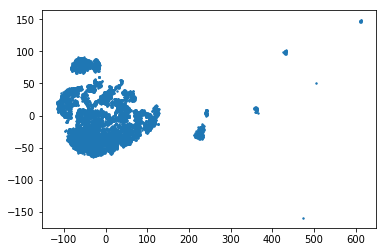

In [109]:
# plot tsne
fig, ax = plt.subplots()
ax.scatter(df_tsne['tsne_x'], df_tsne['tsne_y'], s=2)
# ax.set_xlim([-200, 200])
# ax.set_ylim([-100, 100])
plt.show()

In [163]:
# clustering
df_clst, clst_summary = louvain_jaccard(df, n_pc=50, k=30, sub_ncells=None, output_file=None, sample_column_suffix=None)
output = '/cndd/fangming/integration/clustering_ATAC_test.tsv'
df_clst.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
print(df_clst.shape)
df_clst.head()

03/23/2018 11:28:36 AM Begin louvain jaccard clustering
Input shape (n_obs, n_features): (9787, 53379)
03/23/2018 11:30:25 AM clustering summary: OrderedDict([('nclst', 16), ('n_pc', 50), ('n_cells', 9787), ('time', 109.47724032402039), ('time_clst', 12.206334590911865), ('k', 30)])


(9787, 1)


,cluster_ID
sample,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,cluster_9
AGCGATAGAACCAGGTATTCGTTGTAATCTTA,cluster_11
AGCGATAGAACCAGGTATTCGTTGTATAGCCT,cluster_1
AGCGATAGAACCAGGTGAAGTATGTATAGCCT,cluster_7
AGCGATAGAACCAGGTGGATACTACAGGACGT,cluster_8


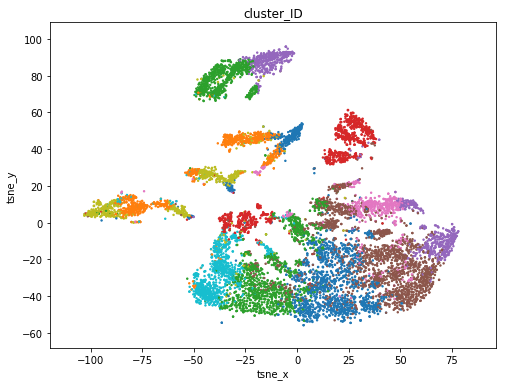

In [172]:
# plot clustering
df_info = pd.merge(df_tsne_atac2, df_clst_atac2, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=-1, s=2, 
#                  t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

In [165]:
df_clst_atac2 = df_clst
df_tsne_atac2 = df_tsne

# ATAC From Rongxin

In [385]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_clst_atac = pd.read_table('XW45_cluster.txt', header=None, names=['sample', 'cluster_ID'], index_col='sample')
    df_tsne_atac = pd.read_table('XW45_tsne.txt', header=None, names=['sample', 'tsne_x', 'tsne_y'], index_col='sample')
    # df_atac = pd.read_table('XW45_gene.txt.gz')
print(df_clst_atac.shape)
print(df_tsne_atac.shape)
df_clst_atac.head()
df_tsne_atac.head()

(8567, 1)
(8567, 2)


,tsne_x,tsne_y
sample,,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,-9.268252,-26.684774
AGCGATAGAACCAGGTAATGACGTCAGGACGT,4.436012,26.133310
AGCGATAGAACCAGGTAGGATAACATAGAGGC,-18.538379,18.408741
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,-5.263620,-22.532956
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,6.972201,-8.754007


In [157]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_atac = pd.read_table('XW45_gene.txt.gz')
df_atac = df_atac.T
print(df_atac.shape)
df_atac.head()

(24848, 8567)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTAATGACGTCAGGACGT,AGCGATAGAACCAGGTAGGATAACATAGAGGC,AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,AGCGATAGAACCAGGTATAGCCTTATAGAGGC,AGCGATAGAACCAGGTATAGCCTTGTACTGAC,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGAGGCGAAG,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,...,TCTCGCGCTTAGCCTCTTGGAAGTATAGAGGC,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTTATAGCCT
Xkr4,2.3293,0.9921,0.0740,1.6337,1.1935,1.3900,0.0000,1.5156,1.7755,1.0137,...,1.1744,1.2613,0.8783,1.1268,1.2383,2.0354,0.5448,1.4776,0.8248,1.5198
Ncaph2,0.7072,0.8949,0.4215,0.5603,0.4907,0.6041,1.3469,0.4354,1.2734,0.7676,...,1.2276,1.6495,1.0536,0.6606,0.4002,0.8459,0.5310,0.3135,0.5910,1.4047
Eif4enif1,0.5953,0.4285,2.9547,0.5595,0.3434,0.4247,2.5039,0.6048,0.8982,0.1843,...,0.6268,0.4233,0.0580,0.6102,0.4689,0.7383,0.3384,0.5968,0.3255,0.6695
Rgr,0.5147,0.2169,0.4826,0.1568,0.0824,0.1683,0.4756,0.4450,0.6172,0.1623,...,0.0668,0.0668,0.3163,1.0814,0.2927,0.4611,0.8932,1.2631,0.1776,0.1806
Mapkapk2,0.8165,0.7324,0.7347,0.6391,1.1717,1.1908,1.0460,1.5550,0.7866,0.5246,...,0.5236,0.8667,0.3547,0.7838,1.0622,0.6283,0.5235,2.6980,0.5169,1.3208


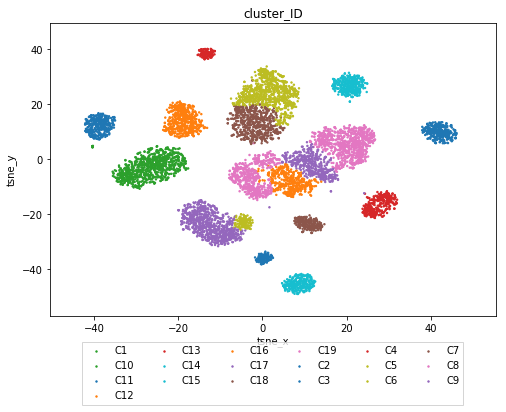

In [20]:
# plot clustering
df_info = pd.merge(df_tsne_atac, df_clst_atac, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=1, s=2, 
#                  t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

# Cluster-wise features 

In [293]:
df_clst = df_clst_atac
df_atac = logtpm

print(df_atac.shape)
df_atac.head()

(53379, 9787)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,AGCGATAGAACCAGGTGGATACTACAGGACGT,AGCGATAGAACCAGGTTAAGATCCGGCTCTGA,AGCGATAGAAGAGGCAAAGGAGTAAGGCGAAG,AGCGATAGAAGAGGCAAAGGCTATATAGAGGC,AGCGATAGAAGAGGCAAAGGCTATCCTATCCT,AGCGATAGAAGAGGCAACTGCATAAGGCGAAG,...,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGATACTAATAGAGGC,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTGCCTTACCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT
gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000064842.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000051951.5,1.937476,0.0,1.947026,1.362701,1.823149,0.0,0.0,1.685893,1.613034,1.366855,...,0.0,1.729973,1.637068,1.839154,0.0,1.791653,2.284388,0.0,0.0,0.0
ENSMUSG00000102851.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
ENSMUSG00000103377.1,2.066262,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [294]:
# get gene*cluster matrix 

clusters_atac = pd.DataFrame() 
for label, df_sub in df_clst.groupby('cluster_ID'):
    samples = df_sub.index.values
    samples = [sample for sample in samples if sample in df_atac.columns.tolist()]
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))
# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.head()

03/29/2018 03:22:16 PM Output shape: (53379, 19)


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19
gene,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000064842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008281,0.000000,0.000000,0.000000,0.009540,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000051951.5,1.253281,0.268029,1.028194,0.371914,1.430407,1.192122,0.854233,1.083997,1.161126,0.567848,1.159349,1.269193,1.060265,0.554364,1.179268,0.207811,1.290441,0.681507,1.017947
ENSMUSG00000102851.1,0.000000,0.007834,0.000000,0.023601,0.000000,0.003021,0.012024,0.003422,0.000000,0.000000,0.017533,0.006750,0.009915,0.011805,0.008826,0.000000,0.000000,0.000000,0.016409
ENSMUSG00000103377.1,0.000000,0.000000,0.024286,0.000000,0.039258,0.035739,0.026746,0.054621,0.050232,0.160652,0.192132,0.042280,0.059163,0.019566,0.112243,0.004640,0.069514,0.010777,0.024636


In [382]:
# correlation 

clusters_atac = clusters_atac[~clusters_atac.index.duplicated(keep='first')]
clusters_mcc = clusters_mcc[~clusters_mcc.index.duplicated(keep='first')]

# index_both = clusters_atac.index.intersection(clusters_mcc.index)
# print(len(index_both))

# most variant genes
top_genes_atac = clusters_atac.std(axis=1).sort_values(ascending=False).head(2000)
top_genes_mcc = clusters_mcc.std(axis=1).sort_values(ascending=False).head(2000)
index_both_top = top_genes_atac.index.intersection(top_genes_mcc.index)

data_atac = clusters_atac.rank(pct=True)
data_atac.columns = ['atac_'+col.strip('cluster_') for col in data_atac.columns]
data_mcc = clusters_mcc.rank(pct=True)
data_mcc.columns = ['methyl_'+col.strip('cluster_') for col in data_mcc.columns]

feature_genes = index_both_top.tolist()

data_atac = data_atac.loc[feature_genes, :]
data_mcc = data_mcc.loc[feature_genes, :]

nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]
print(data_atac.shape)
print(data_mcc.shape)

# feature_genes

(484, 19)
(484, 88)


In [383]:
corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
print(corr.shape)

(107, 107)


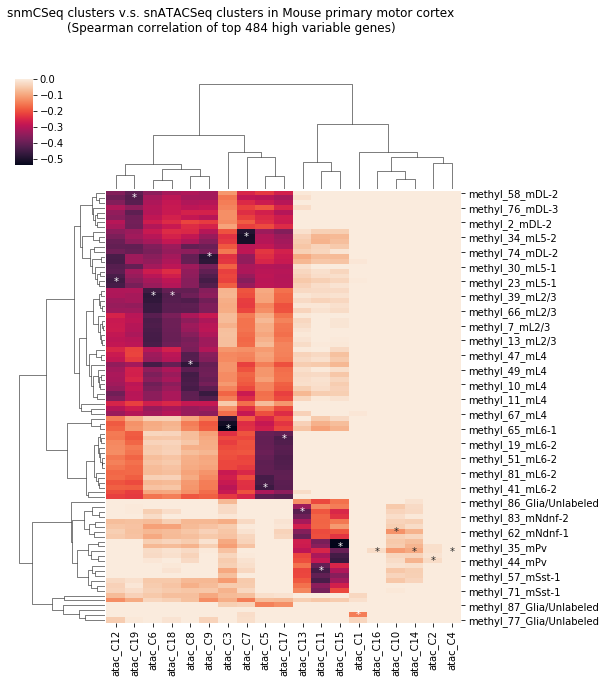

In [384]:
df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
# df_corr = df_corr.T
reject_threshold = 100 

df_corr
df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
for col, idx in df_corr.idxmin().iteritems():
    if df_corr.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot = df_annot.fillna('')

df_corr_zscore = df_corr.apply(zscore, axis=1)
df_annot_zscore = pd.DataFrame(columns=df_corr_zscore.columns, index=df_corr_zscore.index)
for col, idx in df_corr_zscore.idxmin().iteritems():
    if df_corr_zscore.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot_zscore.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot_zscore = df_annot_zscore.fillna('')

g = sns.clustermap(df_corr, 
                   xticklabels=True,
                   yticklabels=True,
                  )
col_orders = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
row_orders = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
plt.close()
g = sns.clustermap(df_corr, 
#                    cmap='Purples', 
                   annot=df_annot.reindex(row_orders, col_orders), fmt='',
#                    xticklabels=True,
#                    yticklabels=True,
                   vmax=0,
                   figsize=(8,10)
                  )
g.fig.suptitle("snmCSeq clusters v.s. snATACSeq clusters in Mouse primary motor cortex\n"
         + "(Spearman correlation of top {} high variable genes)".format(len(feature_genes)))
g.savefig('/cndd/fangming/integration/correlation_snmcseq_vs_snatacseq_{}genes.pdf'.format(len(feature_genes)))
plt.show()

# g = sns.clustermap(df_corr_zscore, cmap='viridis')
# col_orders = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
# row_orders = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
# plt.close()

# g = sns.clustermap(df_corr_zscore, cmap='viridis', 
#                    annot=df_annot_zscore.reindex(row_orders, col_orders), fmt='')
# g.fig.suptitle("snmCSeq clusters v.s. snATACSeq clusters in Mouse primary motor cortex\n"
#          + "(Zscore of spearman correlation of top {} most variant genes)".format(len(feature_genes)))
# fig.savefig('/cndd/fangming/integration/correlation_snmcseq_vs_snatacseq_1.pdf')
# plt.show()


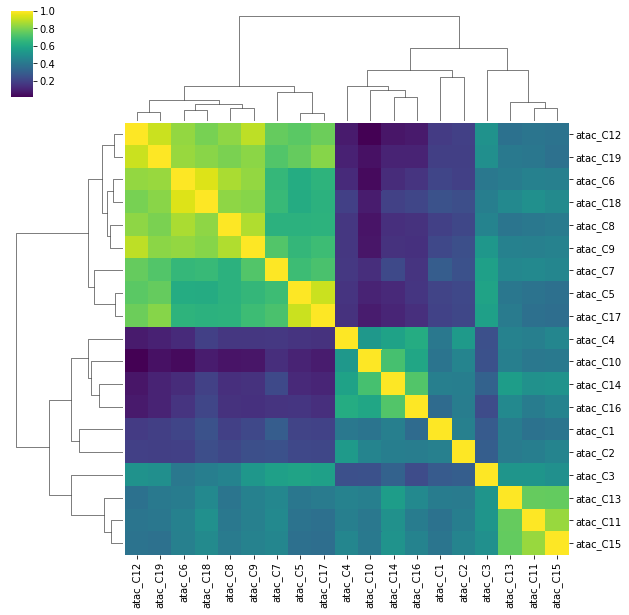

In [290]:
# 

df_corr = pd.DataFrame(corr[:nclst_atac, :nclst_atac], index=data_atac.columns, columns=data_atac.columns)
# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# ax = axs[0]
# sns.heatmap(df_corr, ax=ax, cmap='viridis')
# ax = axs[1]
# sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
# fig.savefig('/cndd/fangming/integration/2.pdf')
# plt.show()

sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
plt.savefig('/cndd/fangming/integration/2-1.pdf')
plt.show()


In [107]:
# df_corr = pd.DataFrame(corr[nclst_atac:, nclst_atac:], index=data_mcc.columns, columns=data_mcc.columns)

# sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
# plt.savefig('/cndd/fangming/integration/3-1.pdf')
# plt.show()

In [111]:
# examples of tSNE plot (our tsne) and logtpm
# exmaples of tSNE plot (their tsne) and logtpm 

def gene_id_to_name(gene_id, df_genes):
    """df_genes
    """
    return df_genes.loc[gene_id, 'gene_name']

def gene_name_to_id(gene_name, df_genes):
    """df_genes
    """
    return df_genes[df_genes['gene_name']==gene_name].index.values[0]

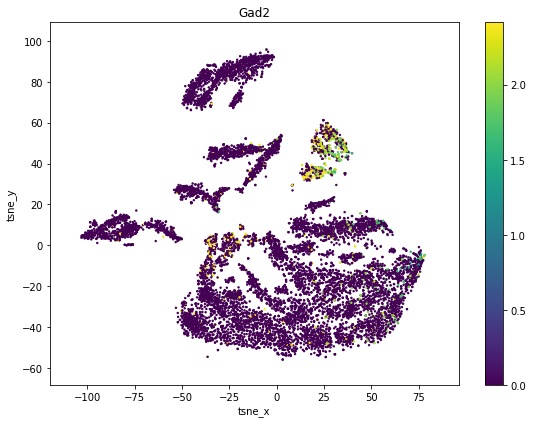

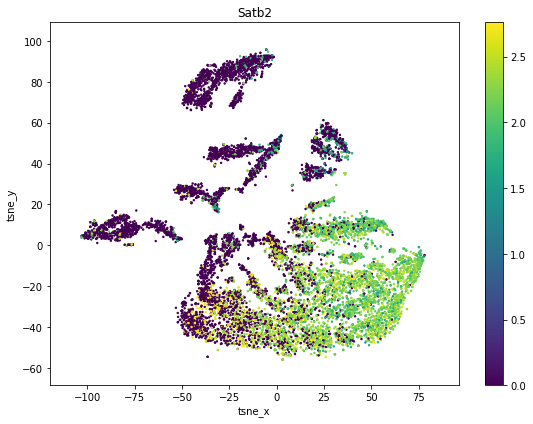

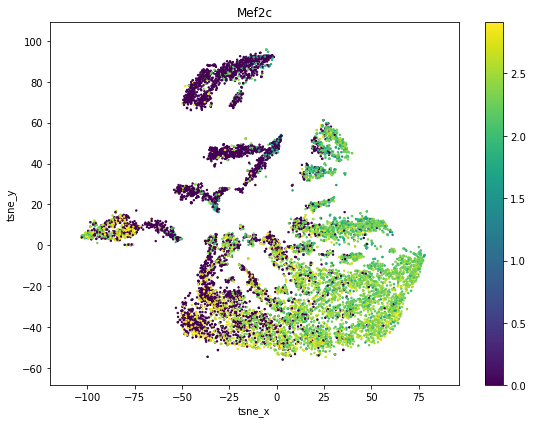

In [430]:
# plot genes 

from snmcseq_utils import plot_tsne_values
gene_names = ['Gad2', 'Satb2', 'Mef2c']
# gene_names = ['Pvalb', 'Lhx6', 'Prox1']
# gene_names = ['Satb2', 'Cux2', 'Foxp2', 'Rorb', 'Tle4']
# gene_names = ['Gfap', 'Sox9', 'Foxp2', 'Rorb', 'Tle4']
# gene_names = ['Slc1a2', 'Csf1r', 'Bin1', 'Epn2']
# gene_names = ['Gad2', 'Vip', 'Pvalb', 'Sst', 'Ndnf']

df_tsne = df_tsne_atac 
df_info = pd.merge(df_clst_2, df_tsne_2, left_index=True, right_index=True)
# for gene_name in gene_names:
#     try:
#         df_gene = df_atac.loc[gene_name_to_id(gene_name, df_genes), :].to_frame(gene_name)
#         df_gene = pd.merge(df_gene, df_info, left_index=True, right_index=True)
#         plot_tsne_values(df_gene, tc=gene_name)
#     except:
#         print(gene_name_to_id(gene_name, df_genes))
for gene_name in gene_names:
    try:
        df_gene = logtpm.loc[gene_name_to_id(gene_name, df_genes), :].to_frame(gene_name)
#         df_gene = df_atac.loc[gene_name, :].to_frame(gene_name)
        df_gene = pd.merge(df_gene, df_info, left_index=True, right_index=True)
        plot_tsne_values(df_gene, tc=gene_name, low_p=2, hi_p=98, 
#                 t_xlim=[-150, 150], t_ylim=[-100, 100]
                        )
    except:
        print(gene_name_to_id(gene_name, df_genes))
        


# ARI

In [426]:
f = '/cndd/fangming/integration/clustering_ATAC_test.tsv'
df_clst_2 = pd.read_table(f, index_col='sample')
f = '/cndd/fangming/integration/tsne_ATAC_test.tsv'
df_tsne_2 = pd.read_table(f, index_col='sample')

df_clst_2.head()
df_clst_atac.head()
df_tsne_atac.head()
df_tsne_2.head()

,tsne_x,tsne_y
sample,,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,75.653830,-4.644841
AGCGATAGAACCAGGTATTCGTTGTAATCTTA,-61.076473,9.013945
AGCGATAGAACCAGGTATTCGTTGTATAGCCT,47.801132,-26.624144
AGCGATAGAACCAGGTGAAGTATGTATAGCCT,38.297615,45.405700
AGCGATAGAACCAGGTGGATACTACAGGACGT,21.550608,19.604294


In [418]:
from sklearn.metrics import adjusted_rand_score

In [419]:
df_info = pd.merge(df_clst_atac, df_clst_2, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne_atac, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne_2, left_index=True, right_index=True)
print(df_info.shape)

adjusted_rand_score(df_info['cluster_ID_x'].values, df_info['cluster_ID_y'].values)

(7683, 6)


0.24171596703995143

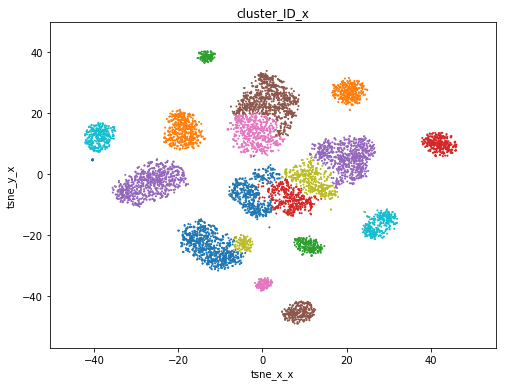

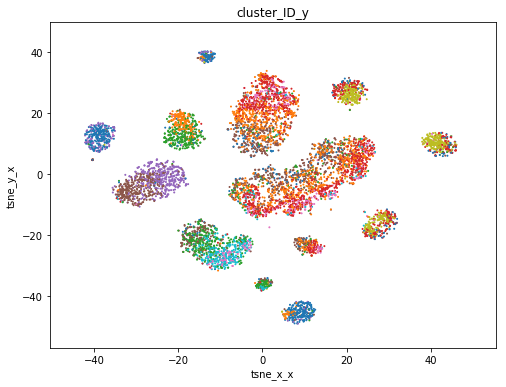

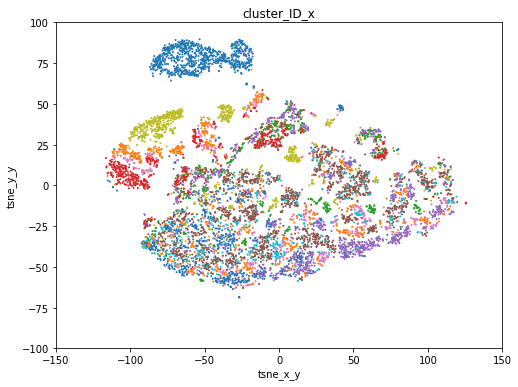

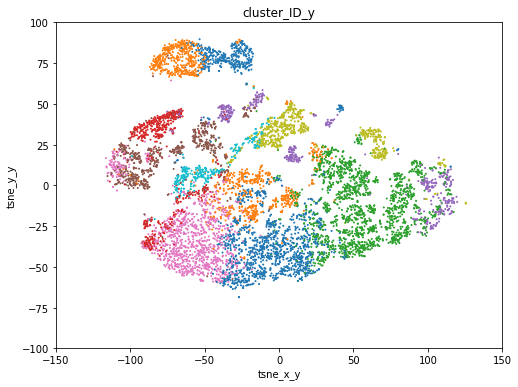

In [420]:
plot_tsne_labels(df_info, tx='tsne_x_x', ty='tsne_y_x', tc='cluster_ID_x', legend_mode=-1)
plot_tsne_labels(df_info, tx='tsne_x_x', ty='tsne_y_x', tc='cluster_ID_y', legend_mode=-1)

plot_tsne_labels(df_info, tx='tsne_x_y', ty='tsne_y_y', tc='cluster_ID_x', legend_mode=-1,
                t_xlim=[-150, 150], t_ylim=[-100, 100])
plot_tsne_labels(df_info, tx='tsne_x_y', ty='tsne_y_y', tc='cluster_ID_y', legend_mode=-1,
                t_xlim=[-150, 150], t_ylim=[-100, 100])